In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from data_fetcher import Dataset
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# List of symbols
symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT', 'DOGEUSDT', 'DOTUSDT', 'XRPUSDT', 'LINKUSDT', 'LTCUSDT', 'BCHUSDT', 'UNIUSDT', 'MATICUSDT', 'SOLUSDT', 'VETUSDT', 'ETCUSDT', 'FILUSDT', 'THETAUSDT', 'XLMUSDT', 'TRXUSDT', 'EOSUSDT']


# Load the cleaned data from the pickle file
pred_copy = 'clean_crypto_data.pkl'

In [2]:
#Defining function for loading data
def load_and_clean_data(pred_copy):
    dt_df = pd.read_pickle(pred_copy)
    dt_df = dt_df.drop(columns=["Name"])
    return dt_df

#Defining function for creating features (future engineering)
def create_features(dt_df, symbols):
    pred_df = dt_df.copy()
    one_day = []
    seven_day = []
    thirty_day = []
    for i in symbols:
        one_day.extend(pred_df[pred_df['symbol']==i].close.shift(-1))
        seven_day.extend(pred_df[pred_df['symbol']==i].close.shift(-7))
        thirty_day.extend(pred_df[pred_df['symbol']==i].close.shift(-30))

    pred_df['t1'] = one_day
    pred_df['t7'] = seven_day
    pred_df['t30'] = thirty_day

    pred_df.dropna(inplace=True)
    return pred_df

#Calling functions
dt_df = load_and_clean_data(pred_copy)
pred_df = create_features(dt_df, symbols)
pred_df.head()

,open,high,low,close,volume,symbol,t1,t7,t30
time,,,,,,,,,
2021-05-20,42849.78,43584.90,30000.00,36690.09,354347.243161,BTCUSDT,40526.64,39241.91,35819.84
2021-05-21,36671.23,42451.67,34850.00,40526.64,203017.596923,BTCUSDT,37252.01,38529.98,35483.72
2021-05-22,40525.39,42200.00,33488.00,37252.01,202100.888258,BTCUSDT,37449.73,35663.49,35600.16
2021-05-23,37263.35,38829.00,35200.62,37449.73,126542.243689,BTCUSDT,34655.25,34605.15,31608.93
2021-05-24,37458.51,38270.64,31111.01,34655.25,217136.046593,BTCUSDT,38796.29,35641.27,32509.56


In [3]:
#Definning function for spltting into test and train
def train_test_split_function(pred_df, symbols):
    X = pred_df.drop(['close', 't1', 't7', 't30'], axis=1)
    y = pred_df[['t1', 't7', 't30']]

    # Map symbols to integers
    symbol_mapping = {symbol: i for i, symbol in enumerate(symbols)}
    X['symbol'] = X['symbol'].map(symbol_mapping)

    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7)
    return X_train, X_test, y_train, y_test

#Definning function for scaling
def data_scaling(X_train, X_test):
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

# Defining the symbol_mapping dictionary
symbol_mapping = {symbol: i for i, symbol in enumerate(symbols)}

X_train, X_test, y_train, y_test = train_test_split_function(pred_df, symbols)
X_train_scaled, X_test_scaled, scaler = data_scaling(X_train, X_test)

print(X_train.head())
print(y_test.head())

                open      high      low        volume  symbol
time                                                         
2023-01-11  272.6000  278.8000  270.200  2.599386e+05       2
2022-04-11  326.0000  332.4000  318.200  3.258391e+04       9
2022-06-03    0.6000    0.6220    0.591  5.508419e+07      11
2022-06-04    0.5872    0.6055    0.539  2.062579e+08       3
2022-06-17    4.4300    4.4700    3.750  4.771731e+06      10
                  t1         t7        t30
time                                      
2022-01-19  41660.01  36958.320  40515.700
2022-03-04   2622.10   2606.700   3443.770
2021-10-26    197.60    197.600    212.200
2022-09-07      1.11      1.087      1.074
2021-11-27     35.16     33.700     31.320


In [4]:
X_train_scaled

array([[4.16037940e-03, 4.11252954e-03, 4.21505046e-03, 1.44152548e-05,
        1.05263158e-01],
       [4.97540898e-03, 4.90321848e-03, 4.96388059e-03, 1.28861791e-06,
        4.73684211e-01],
       [8.91785832e-06, 8.94245587e-06, 8.98081338e-06, 3.17976965e-03,
        5.78947368e-01],
       ...,
       [4.26416594e-03, 4.13760736e-03, 4.15420801e-03, 2.94669411e-05,
        1.05263158e-01],
       [1.13314906e-04, 1.11407481e-04, 1.12865394e-04, 4.54757638e-04,
        2.63157895e-01],
       [5.24106757e-06, 5.18225792e-06, 5.18986084e-06, 1.58489992e-02,
        3.15789474e-01]])

In [5]:
#Definning function for training the model
def model_training(X_train_scaled, y_train):
    # Instantiate the random forest regressor object
    regressor = RandomForestRegressor()
    # Fit the regressor with X and Y data
    regressor.fit(X_train_scaled, y_train)
    return regressor

In [6]:
#Definning function to make prediction
def model_prediction(regressor, X_test_scaled):
    y_pred = regressor.predict(X_test_scaled)
    return y_pred

regressor = model_training(X_train_scaled, y_train)
y_pred = model_prediction(regressor, X_test_scaled)
y_pred

array([[4.20943144e+04, 4.37855092e+04, 4.58927568e+04],
       [2.95282310e+03, 3.13453030e+03, 3.32333200e+03],
       [1.89178000e+02, 1.92659900e+02, 2.03708000e+02],
       ...,
       [2.90733700e+01, 3.11863500e+01, 3.18961100e+01],
       [3.25442000e+01, 3.09563000e+01, 2.54378000e+01],
       [3.94754600e+01, 3.63834100e+01, 3.24764700e+01]])

In [7]:
#Definning functions for calculating metrics
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y_true, y_pred, dataset_type="Test"):
    y_pred_df = pd.DataFrame(y_pred, columns=['t1', 't7', 't30'])
    print(f"------- {dataset_type} Dataset Metrics -------")
    for horizon in ['t1', 't7', 't30']:
        mape = mean_absolute_percentage_error(y_true[horizon], y_pred_df[horizon])
        mae = mean_absolute_error(y_true[horizon], y_pred_df[horizon])
        rmse = np.sqrt(mean_squared_error(y_true[horizon], y_pred_df[horizon]))
        r2 = r2_score(y_true[horizon], y_pred_df[horizon])

        print(f"For {horizon} days:")
        print(f"MAPE : {mape:.2f}")
        print(f"MAE : {mae:.2f}")
        print(f"RMSE : {rmse:.2f}")
        print(f"R2 : {r2:.2f}")
        print()

def calculate_general_metrics(y_true, y_pred, dataset_type="Test"):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"------- {dataset_type} Dataset Overall Metrics -------")
    print(f"MAPE : {mape:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R2 : {r2:.2f}")
    print()

In [8]:
# Train data prediction and metrics
y_train_pred = model_prediction(regressor, X_train_scaled)
calculate_metrics(y_train, y_train_pred, dataset_type="Train")
calculate_general_metrics(y_train, y_train_pred, dataset_type="Train")

------- Train Dataset Metrics -------
For t1 days:
MAPE : 1.83
MAE : 23.30
RMSE : 137.26
R2 : 1.00

For t7 days:
MAPE : 3.71
MAE : 48.72
RMSE : 282.17
R2 : 1.00

For t30 days:
MAPE : 6.33
MAE : 86.62
RMSE : 500.87
R2 : 1.00

------- Train Dataset Overall Metrics -------
MAPE : 3.95
MAE : 52.88
RMSE : 341.24
R2 : 1.00



In [9]:
# Test data prediction and metrics
y_test_pred = model_prediction(regressor, X_test_scaled)
calculate_metrics(y_test, y_test_pred, dataset_type="Test")
calculate_general_metrics(y_test, y_test_pred, dataset_type="Test")

------- Test Dataset Metrics -------
For t1 days:
MAPE : 5.11
MAE : 56.20
RMSE : 299.91
R2 : 1.00

For t7 days:
MAPE : 9.99
MAE : 117.51
RMSE : 671.81
R2 : 0.99

For t30 days:
MAPE : 17.49
MAE : 221.78
RMSE : 1242.84
R2 : 0.97

------- Test Dataset Overall Metrics -------
MAPE : 10.86
MAE : 131.83
RMSE : 833.85
R2 : 0.99



In [10]:
def future_predictions():
    # get current date
    current_date = datetime.now()

    # get the start of last year
    start_of_last_year = datetime(current_date.year - 1, 1, 1)

    # calculate the number of days since the start of last year
    days_since_start_of_last_year = (current_date - start_of_last_year).days

    #BTCUSDT Prediction
    bt_coin = Dataset().get_data(ticker='BTCUSDT', days=days_since_start_of_last_year, ts='1d')

    bt_coin= pd.DataFrame(bt_coin)
    bt_coin['symbol'] = 'BTCUSDT'
    bt_coin.reset_index()

    bt_values = bt_coin.copy()
    bt_values2 = bt_values.drop(['close'], axis=1)
    bt_values2['symbol'] = bt_values2.symbol.map(symbol_mapping)
    btc_scaled = X_test_scaled = scaler.transform(bt_values2)

    bt_values[['t1', 't7', 't30']] = regressor.predict(X_test_scaled)
    bt_values.tail()
    return bt_values

# def plot_future(bt_values):
#     bt_values.t1.plot(figsize=(12,5), title="BTCUSDT Predicted Price for 30 Days")
#     plt.show()

In [11]:
# bt_values = future_predictions()
# plot_future(bt_values)

In [12]:
def predict_smoothed(regressor, df, scaler, symbol_mapping, prediction_days=30, smooth_average=7):
    # Get the current date
    current_date = datetime.now()

    # Prepare the dataset for prediction
    df_copy = df.copy()
    df_copy['symbol'] = df_copy.symbol.map(symbol_mapping)
    df_scaled = scaler.transform(df_copy.drop(['close'], axis=1))

    # Make the prediction and add it to the dataframe
    df[['t1', 't7', 't30']] = regressor.predict(df_scaled)

    # Smoothing the prediction with a rolling mean
    df['plot_me'] = df[f't{prediction_days}'].rolling(smooth_average).mean()

    # Creating a new dataframe for the predicted values
    plot = df[-prediction_days:]['plot_me'].values
    predicted_values = pd.DataFrame({'close': plot}, index=pd.date_range(str(df.tail(1).index.values[0]).split("T")[0], periods=prediction_days, freq='D'))

    # Concatenate the original data with the predicted values
    recent_data = df[['close']]
    recent_data.drop(recent_data.tail(1).index, inplace=True)
    final_pred = pd.concat([recent_data, predicted_values], sort=False)

    return final_pred

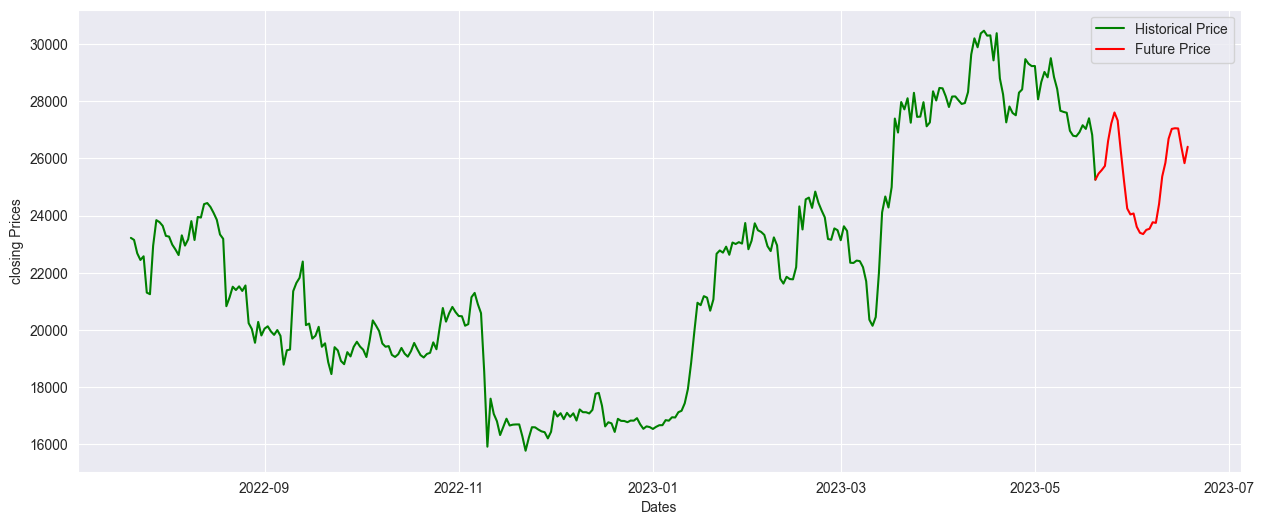

In [13]:
# Getting live data
df = Dataset().get_data(ticker='BTCUSDT', days=(datetime.now() - datetime(datetime.now().year - 1, 1, 1)).days, ts='1d')
df = pd.DataFrame(df)
df['symbol'] = 'BTCUSDT'
df.reset_index()

# Usig the function to make a smoothed prediction
final_pred = predict_smoothed(regressor, df, scaler, symbol_mapping)

# Plot the result
plt.figure(figsize=(15,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('closing Prices')
plt.plot(final_pred[200:-29][['close']], 'green', label='Historical Price')
plt.plot(final_pred[-30:][['close']], 'red', label='Future Price')
plt.legend()
plt.show()

In [14]:
from joblib import dump, load

# saving model
joblib_rForest = "joblib_model1.joblib"
dump(regressor, joblib_rForest)

['joblib_model1.joblib']

In [15]:
# Save to file in the current working directory
joblib_scaler_rForest = "joblib_scaler1.joblib"
dump(scaler, joblib_scaler_rForest)

['joblib_scaler1.joblib']